# Wine Classification - Data Understanding


Exploring the chemical fingerprints that distinguish red from white wines. No modeling yet — just understanding what we're working with.

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Reproducibility
np.random.seed(42)
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')

## 1. Data Loading

### Data Source & License

**Data source & license.** UCI Machine Learning Repository — *Wine Quality* (Cortez et al., 2009), Vinho Verde (Portugal), 2004–2007.  
Laboratory physicochemical measurements + expert "quality" scores.  
Use per UCI terms; redistribute CSVs for research/education.

In [96]:
# Load red and white wine datasets
red_wine = pd.read_csv('../data/winequality-red.csv', sep=';')
white_wine = pd.read_csv('../data/winequality-white.csv', sep=';')

# Add wine type labels - using wine_type for consistency with notebook 01
red_wine['wine_type'] = 0  # Red
white_wine['wine_type'] = 1  # White

# Combine into single dataframe
df = pd.concat([red_wine, white_wine], ignore_index=True)

# Add type names for clearer visualizations
df['type_name'] = df['wine_type'].map({0: 'Red', 1: 'White'})

print(f"Combined dataset shape: {df.shape}")
print(f"Features: {df.shape[1] - 2} physicochemical + quality score")
print(f"Samples: {df.shape[0]:,}")

Combined dataset shape: (6497, 14)
Features: 12 physicochemical + quality score
Samples: 6,497


## 2. Data Quality Check

In [97]:
# Data types and missing values
print("Data types:")
print(df.dtypes)
print("\nMissing values:")
print(df.isnull().sum())
print("\n✅ No missing values — rare luxury!")

Data types:
fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
wine_type                 int64
type_name                object
dtype: object

Missing values:
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
wine_type               0
type_name               0
dtype: int64

✅ No missing values — rare luxury!


## 3. Class Distribution Analysis

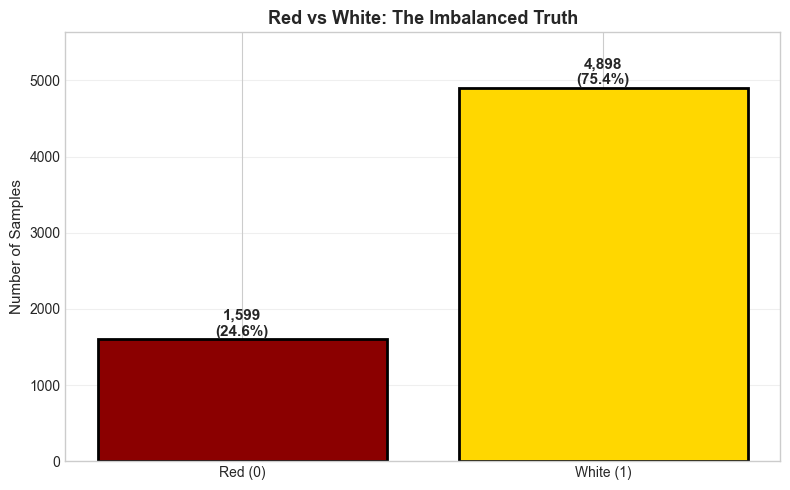

In [98]:
# Class distribution
class_counts = df['wine_type'].value_counts().sort_index()  # 0=red, 1=white
class_pcts = df['wine_type'].value_counts(normalize=True).sort_index() * 100

# Visualization - single clear bar chart
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

# Bar chart with improved title
colors = ['#8B0000', '#FFD700']
bars = ax.bar(['Red (0)', 'White (1)'], class_counts.values, color=colors, edgecolor='black', linewidth=2)
ax.set_ylabel('Number of Samples', fontsize=11)
ax.set_title('Red vs White: The Imbalanced Truth', fontweight='bold', fontsize=13)

# Add count and percentage annotations
for bar, count, pct in zip(bars, class_counts.values, class_pcts.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
             f'{count:,}\n({pct:.1f}%)', ha='center', fontweight='bold', fontsize=11)

ax.set_ylim(0, max(class_counts.values) * 1.15)  # Add headroom for labels
ax.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

**Interpretation.** Whites are ~3× more frequent than reds (≈75% vs 25%).  
This imbalance means **accuracy alone can be misleading**; I'll report **macro-F1** and class-wise metrics later.  
Operationally, false negatives on minority class (red) are costlier if sorting/inventory depends on the label.

## 4. Feature Separation Analysis

In [99]:
# Calculate feature separation (difference in means normalized by pooled std)
feature_cols = df.columns.drop(['quality', 'wine_type', 'type_name'])  # Exclude non-feature columns
separation_scores = {}

for col in feature_cols:
    red_mean = df[df['wine_type'] == 0][col].mean()
    white_mean = df[df['wine_type'] == 1][col].mean()
    pooled_std = np.sqrt((df[df['wine_type'] == 0][col].std()**2 + df[df['wine_type'] == 1][col].std()**2) / 2)
    separation_scores[col] = abs(red_mean - white_mean) / pooled_std

# Top 3 discriminative features
top_features = sorted(separation_scores.items(), key=lambda x: x[1], reverse=True)[:3]
print("Most Discriminative Features (by standardized mean difference):")
for feat, score in top_features:
    print(f"  {feat:25} {score:.2f}")

Most Discriminative Features (by standardized mean difference):
  total sulfur dioxide      2.42
  volatile acidity          1.72
  free sulfur dioxide       1.38


## 5. Deep Dive: Top Discriminative Features

### Feature 1: Total Sulfur Dioxide

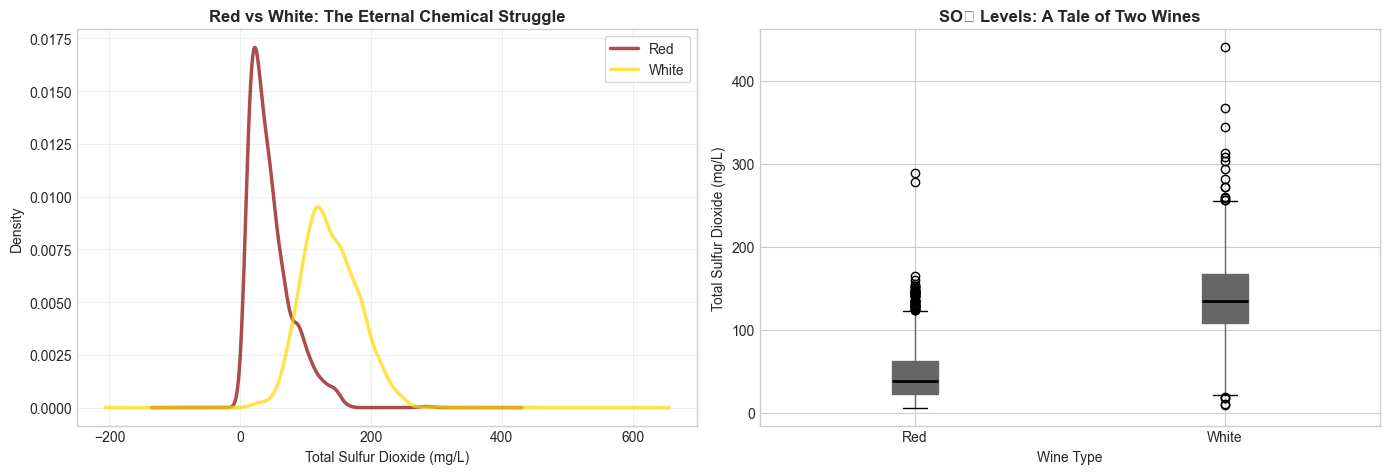

In [100]:
# Total sulfur dioxide distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# KDE plot
for wine_val, color, label in [(0, '#8B0000', 'Red'), (1, '#FFD700', 'White')]:
    data = df[df['wine_type'] == wine_val]['total sulfur dioxide']
    data.plot.kde(ax=ax1, color=color, linewidth=2.5, label=label, alpha=0.7)
ax1.set_xlabel('Total Sulfur Dioxide (mg/L)')
ax1.set_ylabel('Density')
ax1.set_title('Red vs White: The Eternal Chemical Struggle', fontweight='bold', fontsize=12)
ax1.legend(frameon=True, fancybox=True)
ax1.grid(True, alpha=0.3)

# Boxplot
df.boxplot(column='total sulfur dioxide', by='wine_type', ax=ax2, 
           patch_artist=True, medianprops={'color': 'black', 'linewidth': 2})
ax2.set_xlabel('Wine Type')
ax2.set_ylabel('Total Sulfur Dioxide (mg/L)')
ax2.set_title('SO₂ Levels: A Tale of Two Wines', fontweight='bold')
ax2.set_xticklabels(['Red', 'White'])
plt.suptitle('')  # Remove default title

plt.tight_layout()
plt.show()

**Interpretation.**  
White wines average 138 ± 42 mg/L SO₂ vs red wines at 46 ± 33 mg/L — nearly 3× higher.  
White wines pack more SO₂ because their pale complexion needs extra protection from oxidation.  
This is our strongest discriminator between wine types.

### Feature 2: Volatile Acidity

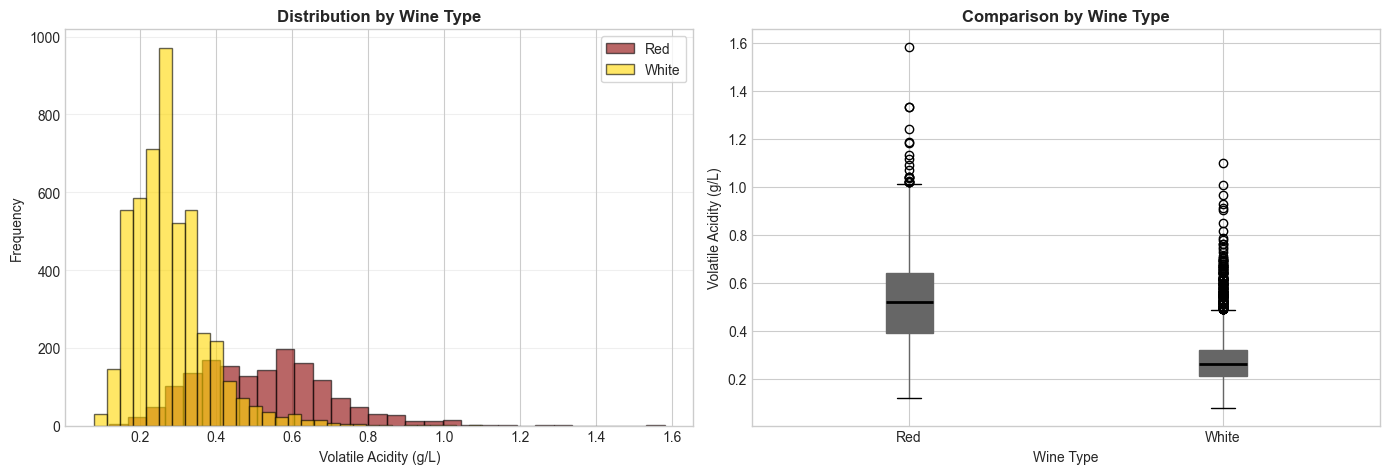

In [101]:
# Volatile acidity distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Histogram with overlap
for wine_val, color, label in [(0, '#8B0000', 'Red'), (1, '#FFD700', 'White')]:
    data = df[df['wine_type'] == wine_val]['volatile acidity']
    ax1.hist(data, bins=30, alpha=0.6, color=color, label=label, edgecolor='black')
ax1.set_xlabel('Volatile Acidity (g/L)')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution by Wine Type', fontweight='bold')
ax1.legend(frameon=True, fancybox=True)
ax1.grid(True, alpha=0.3, axis='y')

# Boxplot
df.boxplot(column='volatile acidity', by='wine_type', ax=ax2,
           patch_artist=True, medianprops={'color': 'black', 'linewidth': 2})
ax2.set_xlabel('Wine Type')
ax2.set_ylabel('Volatile Acidity (g/L)')
ax2.set_title('Comparison by Wine Type', fontweight='bold')
ax2.set_xticklabels(['Red', 'White'])
plt.suptitle('')

plt.tight_layout()
plt.show()

**Interpretation.**  
Reds show ~2× higher volatile acidity (acetic acid) → fermentation effect.  
This reflects different fermentation processes — reds undergo malolactic fermentation.  
Some overlap exists, but distributions are clearly shifted.

### Feature 3: Chlorides

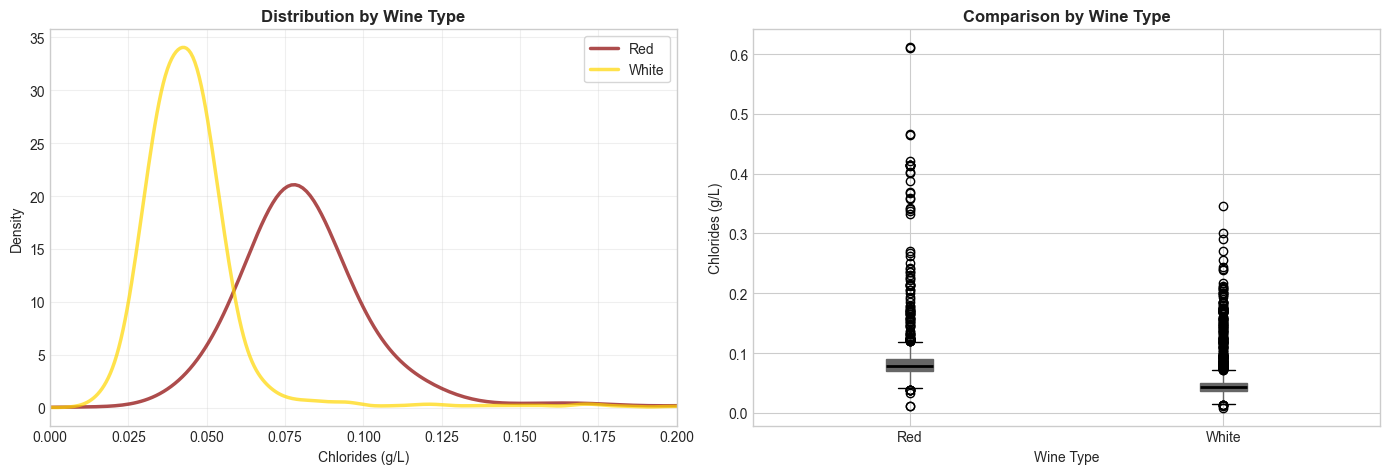

In [102]:
# Chlorides distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# KDE plot
for wine_val, color, label in [(0, '#8B0000', 'Red'), (1, '#FFD700', 'White')]:
    data = df[df['wine_type'] == wine_val]['chlorides']
    data.plot.kde(ax=ax1, color=color, linewidth=2.5, label=label, alpha=0.7)
ax1.set_xlabel('Chlorides (g/L)')
ax1.set_ylabel('Density')
ax1.set_title('Distribution by Wine Type', fontweight='bold')
ax1.legend(frameon=True, fancybox=True)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, 0.2)  # Focus on main distribution

# Boxplot
df.boxplot(column='chlorides', by='wine_type', ax=ax2,
           patch_artist=True, medianprops={'color': 'black', 'linewidth': 2})
ax2.set_xlabel('Wine Type')
ax2.set_ylabel('Chlorides (g/L)')
ax2.set_title('Comparison by Wine Type', fontweight='bold')
ax2.set_xticklabels(['Red', 'White'])
plt.suptitle('')

plt.tight_layout()
plt.show()

**Interpretation.**  
Red wines have notably higher chlorides (saltiness) — median 0.079 g/L vs 0.043 g/L.  
This could relate to different fermentation or soil conditions.  
The outliers suggest some wines push the salt envelope.

## 6. Feature Correlations

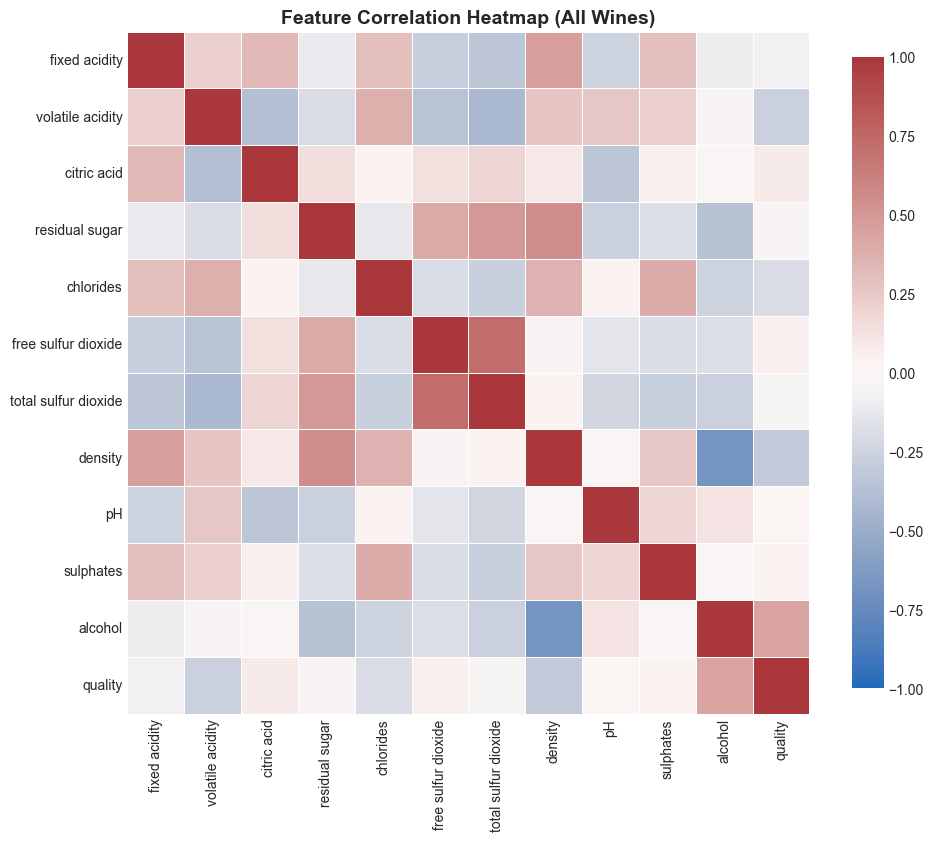

In [103]:
# Correlation heatmap
feat_cols = [c for c in df.columns if c not in ["wine_type", "type_name"]]
corr = df[feat_cols].corr()

plt.figure(figsize=(10, 9))
sns.heatmap(corr, vmin=-1, vmax=1, cmap="vlag", center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
            annot=False)  # Set to True if you want correlation values shown
plt.title("Feature Correlation Heatmap (All Wines)", fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()

## 7. Preprocessing Considerations

Notes for future modeling (notebook 03+):

In [104]:
# Check feature scales
print("Feature Scale Analysis:")
print("="*50)
scale_analysis = pd.DataFrame({
    'Feature': feature_cols,
    'Min': df[feature_cols].min(),
    'Max': df[feature_cols].max(),
    'Range': df[feature_cols].max() - df[feature_cols].min()
}).sort_values('Range', ascending=False)

print(scale_analysis.head().to_string(index=False))

print("\n📝 Preprocessing Notes:")
print("• Features have vastly different scales (e.g., SO₂ in 100s, chlorides in 0.0x)")
print("• StandardScaler needed for distance-based models (KNN, SVM, Logistic Regression)")
print("• Tree-based models (Random Forest, XGBoost) won't need scaling")
print("• CRITICAL: Fit scaler on training set only to prevent data leakage")
print("• Use stratified train/test split (random_state=42); report macro-F1 alongside accuracy")
print("• Consider outlier handling for chlorides and residual sugar")

Feature Scale Analysis:
             Feature  Min   Max  Range
total sulfur dioxide  6.0 440.0  434.0
 free sulfur dioxide  1.0 289.0  288.0
      residual sugar  0.6  65.8   65.2
       fixed acidity  3.8  15.9   12.1
             alcohol  8.0  14.9    6.9

📝 Preprocessing Notes:
• Features have vastly different scales (e.g., SO₂ in 100s, chlorides in 0.0x)
• StandardScaler needed for distance-based models (KNN, SVM, Logistic Regression)
• Tree-based models (Random Forest, XGBoost) won't need scaling
• CRITICAL: Fit scaler on training set only to prevent data leakage
• Use stratified train/test split (random_state=42); report macro-F1 alongside accuracy
• Consider outlier handling for chlorides and residual sugar


## 8. Data Export for Modeling

In [105]:
# Save standardized dataset for consistent loading in subsequent notebooks
out_path = "../data/wine_prepared_v01.csv"
df.to_csv(out_path, index=False)
print(f"✓ Saved: {out_path}")
print(f"  Shape: {df.shape}")
print(f"  Columns: {', '.join(df.columns.tolist())}")

✓ Saved: ../data/wine_prepared_v01.csv
  Shape: (6497, 14)
  Columns: fixed acidity, volatile acidity, citric acid, residual sugar, chlorides, free sulfur dioxide, total sulfur dioxide, density, pH, sulphates, alcohol, quality, wine_type, type_name


## 9. Key Takeaways

1. **Strong class imbalance** (75% white, 25% red) — use stratified splits and balanced metrics
2. **Excellent separability** in total SO₂, volatile acidity, and chlorides
3. **No missing data** — rare luxury in real-world datasets
4. **Scale normalization required** for linear models
5. **Outliers present** but shouldn't break tree-based approaches
6. **Multicollinearity detected** between SO₂ measures and density-related features
7. **Data exported** to `wine_prepared_v01.csv` for consistent modeling

Ready for modeling in notebook 03!